# Session 4: Logistic Regression

In this exercise, you will implement logistic regression and apply it to two different datasets.


<a name="1"></a>
## 1 - Imports and Extra Code

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
-  ``utils.py`` contains helper functions for this assignment. You do not need to modify code in this file.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

%matplotlib inline

In [48]:
def load_data_1():
    data = np.loadtxt(r"C:\Users\nickl\Documents\MI\ex2data1.txt", delimiter=',',skiprows=0)
    X = data[:,:2]
    y = data[:,2]

    np.random.seed(1)
    X = X + np.random.normal(0, 0.25, size=X.shape)

    X = zscore_normalize_features(X)

    return X, y

def load_data_2():
    data = np.loadtxt(r"C:\Users\nickl\Documents\MI\ex2data2.txt", delimiter=',',skiprows=0)
    X = data[:,:2]
    y = data[:,2]

    X = zscore_normalize_features(X)

    np.random.seed(1)
    X = X + np.random.normal(0, 0.25, size=X.shape)

    return X, y

In [49]:
def plot_data(X, y, pos_label="Admitted", neg_label="Non Admitted"):
    positive = y == 1
    negative = y == 0

    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)
    plt.legend()

def sig(z):
    return 1/(1+np.exp(-z))

def plot_decision_boundary(w, b, X, y, plot_label, pos_label="Admitted", neg_label="Non Admitted"):
    # Credit to dibgerge on Github for this plotting code

    plot_data(X[:, 0:2], y, pos_label= pos_label,  neg_label = neg_label)

    if X.shape[1] <= 2:
      plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
      plot_y = (-1. / w[1]) * (w[0] * plot_x + b)

      plt.plot(plot_x, plot_y, c="b", label = "Decision Boundary")
    else:
        u = np.linspace(-2.5, 2.5, 50)
        v = np.linspace(-2.5, 2.5, 50)

        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)

        # important to transpose z before calling contour
        z = z.T

        # Plot z = 0
        plt.contour(u,v,z, levels = [0.5], colors="g")


    plt.title(plot_label+ ":  Accuracy: %.2f"%accuracy(X, y, w, b))
    plt.legend()
    plt.show()

def plot_decision_boundaries(w, b, X, y, pos_label="Admitted", neg_label="Non Admitted"):
    # Credit to dibgerge on Github for this plotting code

    X_split_train, y_split_train, X_split_val, y_split_val = split_data(X, y)

    plot_decision_boundary(w, b, X_split_train, y_split_train, "Training Data", pos_label, neg_label)

    plot_decision_boundary(w, b, X_split_val, y_split_val, "Test Data", pos_label, neg_label)



def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    X_mean     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    X_sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - X_mean) / X_sigma

    return X_norm

def split_data(X, y):
    #Permutate the data
    np.random.seed(123)
    perm = np.random.permutation(X.shape[0])
    X = X[perm,:]
    y = y[perm]

    #Split the data
    size_train = int(0.66*X.shape[0])
    X_split_train, y_split_train = X[0:size_train,:], y[0:size_train]
    X_split_val, y_split_val = X[size_train:,:], y[size_train:]

    return X_split_train, y_split_train, X_split_val, y_split_val

def accuracy(X, y, w, b):
    p = (sigmoid(np.dot(X, w) + b) >=0.5)
    return np.mean(p == y) * 100



In [50]:
import urllib
from urllib.request import urlopen


def feedback(excercise_id, finished=True, understood=True, comment="No comments"):
  base_url = "https://docs.google.com/forms/d/e/"
  base_url += "1FAIpQLSeg4_ljWJ7vlvrqobuo8WmpKe3vuXZKwcuJosVj67XClvJEHA"
  base_url += "/formResponse?"
  base_url += "entry.2058183318=" + excercise_id
  base_url += "&entry.217828241=" + ("Yes" if finished else "No")
  base_url += "&entry.676697552=" + ("Yes" if understood else "No")
  base_url += "&entry.379660172=" + comment

  base_url = base_url.replace(" ", "%20")
  urlopen(base_url)
  print("FEEDBACK SUBMITTED. THANKS!!! :D")


<a name="2"></a>
## 2 - Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

<a name="2.1"></a>
### 2.1 Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams.
* You have historical data from previous applicants that you can use as a training set for logistic regression.
* For each training example, you have the applicant’s scores on two exams and the admissions decision.
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams.

<a name="2.2"></a>
### 2.2 Loading and visualizing the data

You will start by loading the dataset for this task.
- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains exam scores on two exams for a student
  - `y_train` is the admission decision
      - `y_train = 1` if the student was admitted
      - `y_train = 0` if the student was not admitted
  - Both `X_train` and `y_train` are numpy arrays.


In [51]:
# load dataset
X_train, y_train = load_data_1()

#### View the variables
Let's get more familiar with your dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first five values of `X_train` and the type of the variable.

In [52]:
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First five elements in X_train are:
 [[-1.58737656  0.63087591]
 [-1.83968448 -1.22308491]
 [-1.5338615   0.33068311]
 [-0.26302411  1.07732598]
 [ 0.69411038  0.49067327]]
Type of X_train: <class 'numpy.ndarray'>


Now print the first five values of `y_train`

In [53]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in y_train are:
 [0. 0. 0. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions. Let's print the shape of `X_train` and `y_train` and see how many training examples we have in our dataset.

In [55]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


#### Visualize your data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.
- The code below displays the data on a 2D plot (as shown below), where the axes are the two exam scores, and the positive and negative examples are shown with different markers.



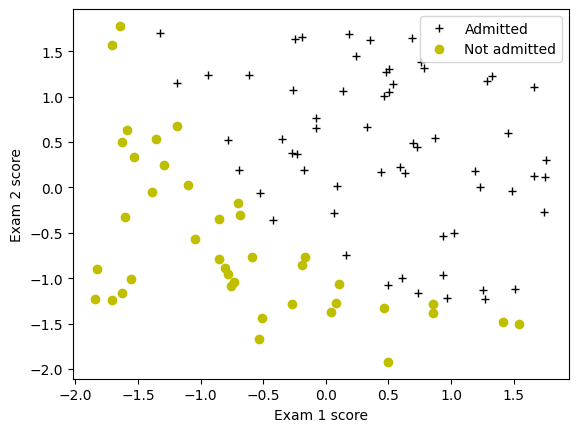

In [56]:
# Plot examples
positive = (y_train == 1)
negative = (y_train == 0)

# Plot examples
plt.plot(X_train[positive, 0], X_train[positive, 1], 'k+', label="Admitted")
plt.plot(X_train[negative, 0], X_train[negative, 1], 'yo', label="Not admitted")


# Set the y-axis label
plt.ylabel('Exam 2 score')
# Set the x-axis label
plt.xlabel('Exam 1 score')
plt.legend(loc="upper right")
plt.show()

Your goal is to build a logistic regression model to fit this data.
- With this model, you can then predict if a new student will be admitted based on their scores on the two exams.

<a name="2.3"></a>
### 2.3  Logistic Regression Model

Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

Let's implement the sigmoid function first, so it can be used by the rest of this assignment.



<a name='ex-01'></a>
### Exercise 1A: Implement Sigmoid Function


Please complete  the `sigmoid` function to calculate

$$g(z) = \frac{1}{1+e^{-z}}$$

Note that
- `z` is not always a single number, but can also be an array of numbers.
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [57]:
# UNQ_C1
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z

    """

    ### START CODE HERE ###
    g = 1/(1 + np.exp(-z))
    ### END SOLUTION ###

    return g

When you are finished, try testing a few values by calling `sigmoid(x)` in the cell below.
- For large positive values of x, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0.
- Evaluating `sigmoid(0)` should give you exactly 0.5.


In [58]:
print ("sigmoid(0) = " + str(sigmoid(0)))

sigmoid(0) = 0.5


**Expected Output**:
<table>
  <tr>
    <td> <b>sigmoid(0)<b></td>
    <td> 0.5 </td>
  </tr>
</table>
    
- As mentioned before, your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid function on every element.

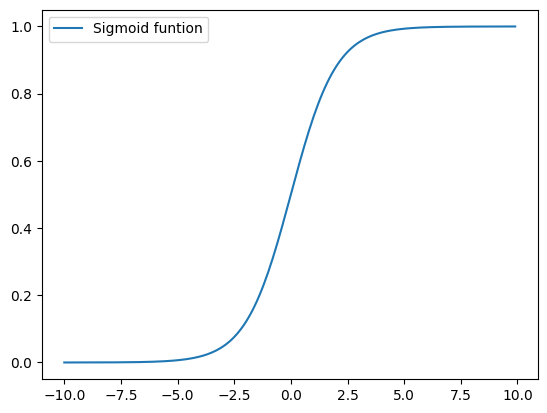

In [59]:
#Let us plot the sigmoid function

x = np.arange(-10,10,0.1)
plt.plot(x,sigmoid(x), label="Sigmoid funtion")
plt.legend()


### Exercise 1A: Plot Decision Boundary



The function `compute_model_output`  computes the output of a linear regression model given a vector of $x$ values and a two parameters $w$ and $b$.

> **Note**: The argument description `(ndarray (m,))` describes a Numpy n-dimensional array of shape (m,). `(scalar)` describes an argument without dimensions, just a magnitude.  
> **Note**: `np.zero(n)` will return a one-dimensional numpy array with $n$ entries   


In [60]:
def compute_model_output(x, w, b):
    """
    Computes the prediction of a linear model
    Args:
      x (ndarray (m,)): Data, m examples
      w,b (scalar)    : model parameters
    Returns
      y (ndarray (m,)): target values
    """

    f_wb=sigmoid(np.dot(x,w) + b)
    return f_wb

Now let's call the `compute_model_output` function and plot the output..

In [61]:
x = [[1, 0]]
w = [1, 10]
b = 0
print(f"w: {w}")
print(f"b: {b}")

w: [1, 10]
b: 0


In [62]:
print ("f(x,w,b) = " + str(compute_model_output(x,w,b)))

f(x,w,b) = [0.73105858]


**Expected Output**:
<table>
  <tr>
    <td> <b>compute_model_output(x,w,b)<b></td>
    <td> 0.73105858 </td>
  </tr>
</table>
    

Plot the decision boundary for a given model

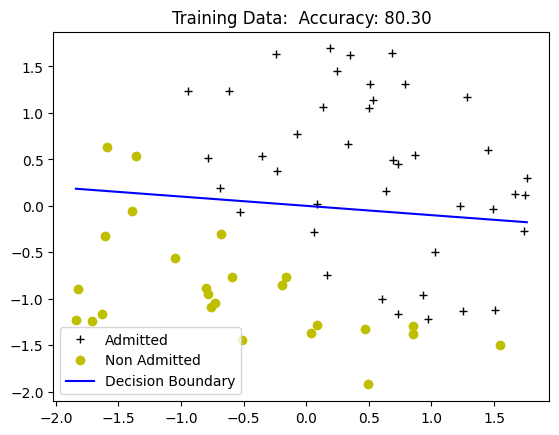

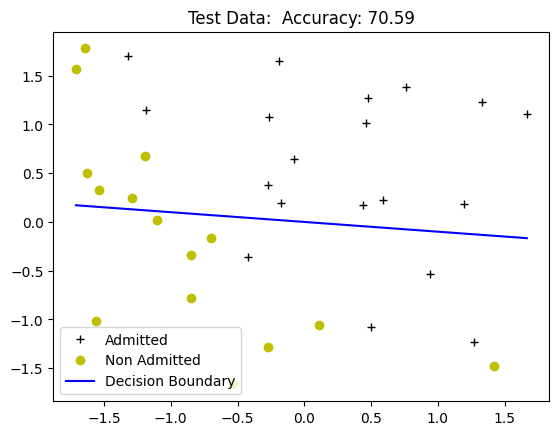

In [63]:
plot_decision_boundaries(w, b, X_train, y_train)


---
SUBMIT FEEDBACK


---



---




<a name="2.4"></a>
### 2.4 Cost function for logistic regression

In this section, you will implement the cost function for logistic regression.




Please complete the `compute_cost` function using the equations below.

Recall that for logistic regression, the cost function is of the form


$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is -

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.


Note:
* As you are doing this, remember that the variables `X_train` and `y_train` are not scalar values but matrices of shape ($m, n$) and ($𝑚$,1) respectively, where  $𝑛$ is the number of features and $𝑚$ is the number of training examples.
* You can use the sigmoid function that you implemented above for this part.

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [64]:
def compute_cost(X, y, w, b, lambda_= 1):
  """
  Computes the cost over all examples
  Args:
    X : (ndarray Shape (m,n)) data, m examples by n features
    y : (array_like Shape (m,)) target value
    w : (array_like Shape (n,)) Values of parameters of the model
    b : scalar Values of bias parameter of the model
    lambda_: unused placeholder
  Returns:
    total_cost: (scalar)         cost
  """

  m, n = X.shape

  ### START CODE HERE ###
  # Compute the linear combination of inputs and weights
  logit = np.clip(np.dot(X, w) + b, -10, 10)
  
  # Apply the sigmoid function to get the predicted probabilities
  f_w = sigmoid(logit)
  
  # Compute the cost using the logistic regression cost function
  total_cost = -np.mean(y*np.log(f_w) + (1-y)*np.log(1-f_w))
  ### END CODE HERE ###

  return total_cost

Run the cells below to check your implementation of the `compute_cost` function with two different initializations of the parameters $w$

In [65]:
m, n = X_train.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))

Cost at initial w (zeros): 0.693


<a name="2.5"></a>
### 2.5 Gradient for logistic regression

In this section, you will implement the gradient for logistic regression.

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously



The `compute_gradient` function computes $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


- **Note**: While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $f_{\mathbf{w},b}(x)$.

As before, you can use the sigmoid function that you implemented above and if you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [66]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient
def compute_gradient(X, y, w, b, lambda_=None):
    """
    Computes the gradient for logistic regression

    Args:
      X : (ndarray Shape (m,n)) variable such as house size
      y : (array_like Shape (m,1)) actual value
      w : (array_like Shape (n,1)) values of parameters of the model
      b : (scalar)                 value of parameter of the model
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w.
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ###

    f_w = sigmoid(np.dot(X, w) + b)
    err = (f_w - y)
    dj_dw = (1/m)*np.dot(X.T, err)
    dj_db = (1/m)*np.sum(err)

    ### END CODE HERE ###


    return dj_db, dj_dw

Run the cells below to check your implementation of the `compute_gradient` function with two different initializations of the parameters $w$

In [67]:
# Compute and display gradient with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-0.28191789900200925, -0.25110716602325084]


<a name="2.6"></a>
### 2.6 Learning parameters using gradient descent

Similar to the previous assignment, you will now find the optimal parameters of a logistic regression model by using gradient descent.
- You don't need to implement anything for this part. Simply run the cells below.

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step.

- Assuming you have implemented the gradient and computed the cost correctly, your value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [68]:
def gradient_descent_val(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    #Permutate the data
    np.random.seed(123)
    perm = np.random.permutation(X.shape[0])
    X = X[perm,:]
    y = y[perm]

    #Split the data
    size_train = int(0.66*X.shape[0])
    X_split_train, y_split_train = X[0:size_train,:], y[0:size_train]
    X_split_val, y_split_val = X[size_train:,:], y[size_train:]

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history_train = []
    J_history_train_acc = []
    J_history_test = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X_split_train, y_split_train, w, b, lambda_)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history_train.append( cost_function(X_split_train, y_split_train, w, b))
            J_history_train_acc.append( accuracy(X_split_train, y_split_train, w, b))
            J_history_test.append( accuracy(X_split_val, y_split_val, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 50) == 0:
            print(f"Iteration {i:4d}: Training Cost {J_history_train[-1]:8.2f}, Train Accuracy {J_history_train_acc[-1]:8.2f}, Test Accuracy {J_history_test[-1]:8.2f}   ")


    it = np.arange(0,num_iters,1)
    plt.plot(it, J_history_train, label="Training Cost")
    plt.plot(it, J_history_train_acc, label="Training Accuracy")
    plt.plot(it, J_history_test, label = "Test Accuracy")
    plt.legend()
    plt.show()

    return w, b, J_history_train, J_history_test


Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

**Note**

The code block below takes a couple of minutes to run, especially with a non-vectorized version. You can reduce the `iterations` to test your implementation and iterate faster. If you have time, try running 100,000 iterations for better results.

<a name='ex-02'></a>
### Exercise 2: Learn the Logistic Regression Model

We will now use the final parameters from gradient descent to plot the linear fit.

Iteration    0: Training Cost     4.91, Train Accuracy    37.88, Test Accuracy    44.12   
Iteration   20: Training Cost     3.81, Train Accuracy    37.88, Test Accuracy    44.12   
Iteration   40: Training Cost     2.73, Train Accuracy    37.88, Test Accuracy    44.12   
Iteration   60: Training Cost     1.78, Train Accuracy    37.88, Test Accuracy    47.06   
Iteration   80: Training Cost     1.17, Train Accuracy    54.55, Test Accuracy    52.94   
Iteration  100: Training Cost     0.84, Train Accuracy    66.67, Test Accuracy    61.76   
Iteration  120: Training Cost     0.64, Train Accuracy    74.24, Test Accuracy    67.65   
Iteration  140: Training Cost     0.51, Train Accuracy    74.24, Test Accuracy    73.53   
Iteration  160: Training Cost     0.42, Train Accuracy    77.27, Test Accuracy    79.41   
Iteration  180: Training Cost     0.36, Train Accuracy    80.30, Test Accuracy    79.41   
Iteration  200: Training Cost     0.32, Train Accuracy    80.30, Test Accuracy    79.41   

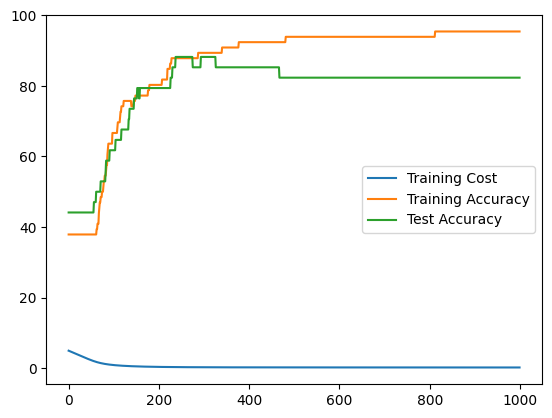

In [69]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 1000
alpha = 0.1

w,b, J_history_train, J_history_test = gradient_descent_val(X_train ,y_train, initial_w, initial_b,
                                   compute_cost, compute_gradient, alpha, iterations, 0)

In [70]:
print(w)
print(b)

[2.97277279 3.48337225]
1.8406671203645515


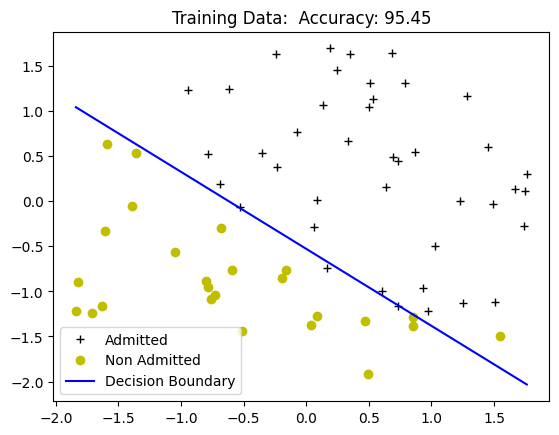

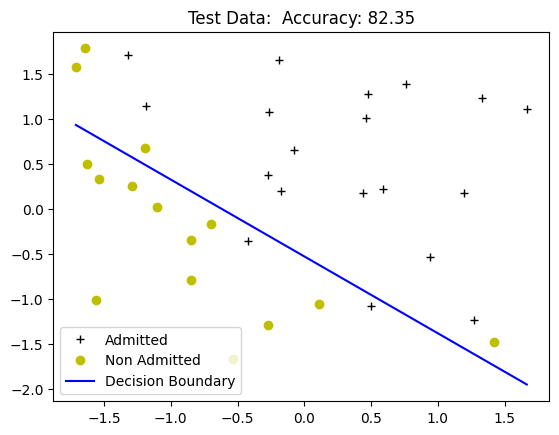

In [71]:
plot_decision_boundaries(w, b, X_train, y_train)


---
SUBMIT FEEDBACK


---



---




<a name="2.8"></a>
### 2.8 Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set.

You will implement the `predict` function below to do this.



The `predict` function produces `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example
    - You've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$
    
If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [72]:
# UNQ_C4
# GRADED FUNCTION: predict

def predict(X, w, b):
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w

    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    ### START CODE HERE ###

    f_w = sigmoid(np.dot(X, w) + b)
    p = (f_w >=0.5)

    ### END CODE HERE ###
    return p

Once you have completed the function `predict`, let's run the code below to report the training accuracy of your classifier by computing the percentage of examples it got correct.

Now let's use this to compute the accuracy on the training set

In [73]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 91.000000


<a name="3"></a>
## 3 - Regularized Logistic Regression

In this part of the exercise, you will implement regularized logistic regression

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

### 3.1 Cost function for regularized logistic regression

In this part, you will implement the cost function for regularized logistic regression.

Recall that for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Compare this to the cost function without regularization (which you implemented above), which is of the form

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$
Note that the $b$ parameter is not regularized.

<a name='ex-05'></a>
### Exercise 3

Please complete the `compute_cost_reg` function below to calculate the following term for each element in $w$
$$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

The starter code then adds this to the cost without regularization (which you computed above in `compute_cost`) to calculate the cost with regulatization.

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [74]:
# UNQ_C5
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value
      w : (array_like Shape (n,)) Values of parameters of the model
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost
    """

    m, n = X.shape

    # Calls the compute_cost function that you implemented above
    cost_without_reg = compute_cost(X, y, w, b)

    ### START CODE HERE ###

    # You need to calculate this value
    reg_cost =  (lambda_/(2*m)) * np.sum(np.square(w))

    ### END CODE HERE ###

    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg +  reg_cost

    return total_cost

Run the cell below to check your implementation of the `compute_cost_reg` function.

In [75]:
np.random.seed(10)
initial_w = np.random.rand(X_train.shape[1])
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_train, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)


Regularized cost : 0.5204570358883369


**Expected Output**:
<table>
  <tr>
    <td> <b>Regularized cost : <b></td>
    <td> 0.5189723414816212 </td>
  </tr>
</table>


---
SUBMIT FEEDBACK


---



---




<a name="3.5"></a>
### 3.2 Gradient for regularized logistic regression

In this section, you will implement the gradient for regularized logistic regression.


The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is a scalar, the other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^\mathrm{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})  $$

$$
\frac{\partial J(\mathbf{w}, b)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=0}^{m-1} (f_{\mathbf{w}, b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j \quad \text{for } j=0 \ldots (n-1)
$$

Compare this to the gradient of the cost function without regularization (which you implemented above), which is of the form
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$


As you can see,$\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same, the difference is the following term in $\frac{\partial J(\mathbf{w},b)}{\partial w}$, which is 
$$
\frac{\lambda}{m} w_j \quad \text{for } j=0 \ldots (n-1)
$$





<a name='ex-04'></a>
### Exercise 4

Please complete the `compute_gradient_reg` function below to modify the code below to calculate the following term

$$
\frac{\lambda}{m} w_j \quad \text{for } j=0\ldots (n-1)
$$

The starter code will add this term to the $\frac{\partial J(\mathbf{w},b)}{\partial w}$ returned from `compute_gradient` above to get the gradient for the regularized cost function.


If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [76]:
# UNQ_C6
def compute_gradient_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the gradient for linear regression

    Args:
      X : (ndarray Shape (m,n))   variable such as house size
      y : (ndarray Shape (m,))    actual value
      w : (ndarray Shape (n,))    values of parameters of the model
      b : (scalar)                value of parameter of the model
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b.
      dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w.

    """
    m, n = X.shape

    dj_db, dj_dw = compute_gradient(X, y, w, b)

    ### START CODE HERE ###

    dj_dw += (lambda_/m)  * w

    ### END CODE HERE ###

    return dj_db, dj_dw

Run the cell below to check your implementation of the `compute_gradient_reg` function.

In [77]:
np.random.seed(1)
initial_w  = np.random.rand(X_train.shape[1])
initial_b = 0.5

lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_train, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )


dj_db: 0.0061062103739540595
First few elements of regularized dj_dw:
 [-0.19441802475337505, -0.0942039631069562]


**Expected Output**:
<table>
  <tr>
    <td> <b>dj_db:</b>-0.0061062103739540595</td> </tr>
  <tr>
      <td> <b> First few elements of regularized dj_dw:</b> </td> </tr>
   <tr>
   <td> [-0.19441802475337505, -0.0942039631069562] </td>
  </tr>
</table>


---
SUBMIT FEEDBACK


---



---




### 3.4 Learning parameters using gradient descent

Similar to the previous parts, you will use your gradient descent function implemented above to learn the optimal parameters $w$,$b$.
- If you have completed the cost and gradient for regularized logistic regression correctly, you should be able to step through the next cell to learn the parameters $w$.
- After training our parameters, we will use it to plot the decision boundary.


### Exercise 5

- Train the model for each lambda parameter.

- See how changing lambda affects the decision boundary.

- See how changing lambda affects the classification accuracy.

- Go to section 3.3. and change the number of degrees and repeat all the process again.

In [78]:
intial_w.shape

(2, 1)

Iteration    0: Training Cost     4.57, Train Accuracy    37.88, Test Accuracy    44.12   
Iteration  200: Training Cost     0.46, Train Accuracy    80.30, Test Accuracy    79.41   
Iteration  400: Training Cost     0.30, Train Accuracy    90.91, Test Accuracy    85.29   
Iteration  600: Training Cost     0.30, Train Accuracy    93.94, Test Accuracy    82.35   
Iteration  800: Training Cost     0.31, Train Accuracy    93.94, Test Accuracy    82.35   
Iteration 1000: Training Cost     0.32, Train Accuracy    95.45, Test Accuracy    82.35   
Iteration 1200: Training Cost     0.34, Train Accuracy    95.45, Test Accuracy    82.35   
Iteration 1400: Training Cost     0.35, Train Accuracy    95.45, Test Accuracy    82.35   
Iteration 1600: Training Cost     0.36, Train Accuracy    95.45, Test Accuracy    82.35   
Iteration 1800: Training Cost     0.38, Train Accuracy    95.45, Test Accuracy    82.35   
Iteration 2000: Training Cost     0.39, Train Accuracy    95.45, Test Accuracy    82.35   

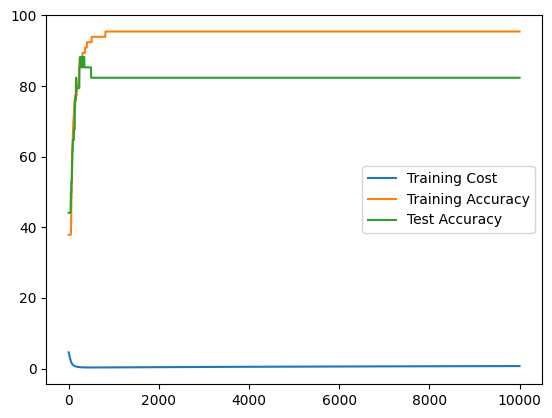

In [79]:
np.random.seed(0)
initial_w = np.random.rand(X_train.shape[1])
initial_b = -8

lambda_=0
# Some gradient descent settings
iterations = 10000
alpha = 0.1

w,b, J_history,_ = gradient_descent_val(X_train, y_train, initial_w, initial_b,
                                    compute_cost_reg, compute_gradient_reg,
                                    alpha, iterations, lambda_)

### 3.5 Plotting the decision boundary
To help you visualize the model learned by this classifier, we will use our `plot_decision_boundary` function which plots the (non-linear) decision boundary that separates the positive and negative examples.

- In the function, we plotted the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then drew a contour plot of where the predictions change from y = 0 to y = 1.

- After learning the parameters $w$,$b$, the next step is to plot a decision boundary.



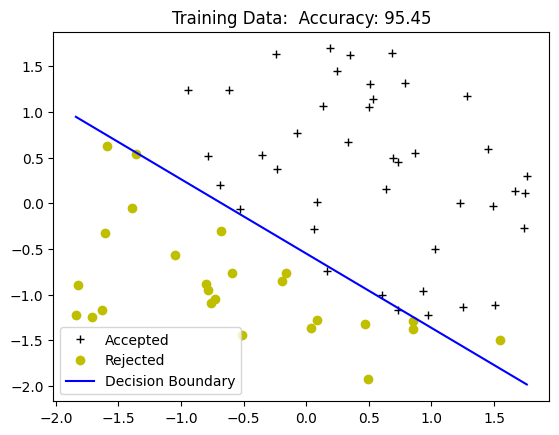

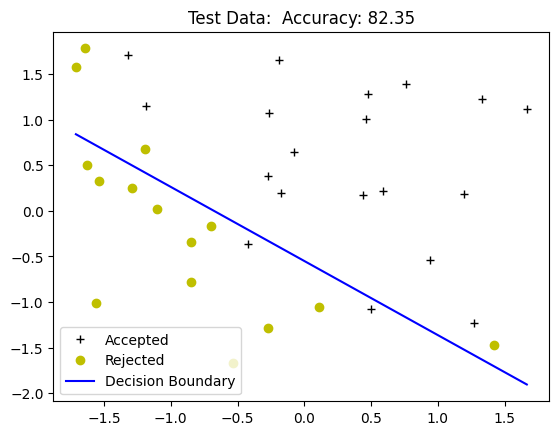

In [80]:
plot_decision_boundaries(w, b, X_train, y_train, pos_label="Accepted", neg_label="Rejected")


---
SUBMIT FEEDBACK


---



---


